This is the simple background comb image, which takes the raw image from the folders

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from scipy.stats import mode
import math
import tempfile
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
base_folder = "/home/beesbook/mnt/scratch/beesbook2024/extracted_frames/"
datecam_folders = ["20240720/cam-0", "20240725/cam-1","20240621/cam-1","20240720/cam-2","20240621/cam-3"]

Number of images to process: 120
Image shape: 4608 5312
Number of median images to compute: 111


Computing rolling medians:   0%|          | 0/111 [00:00<?, ?it/s]

Rolling median computation complete.
Processing image in 9 x 11 tiles.
Background image computed, shape: (4608, 5312)


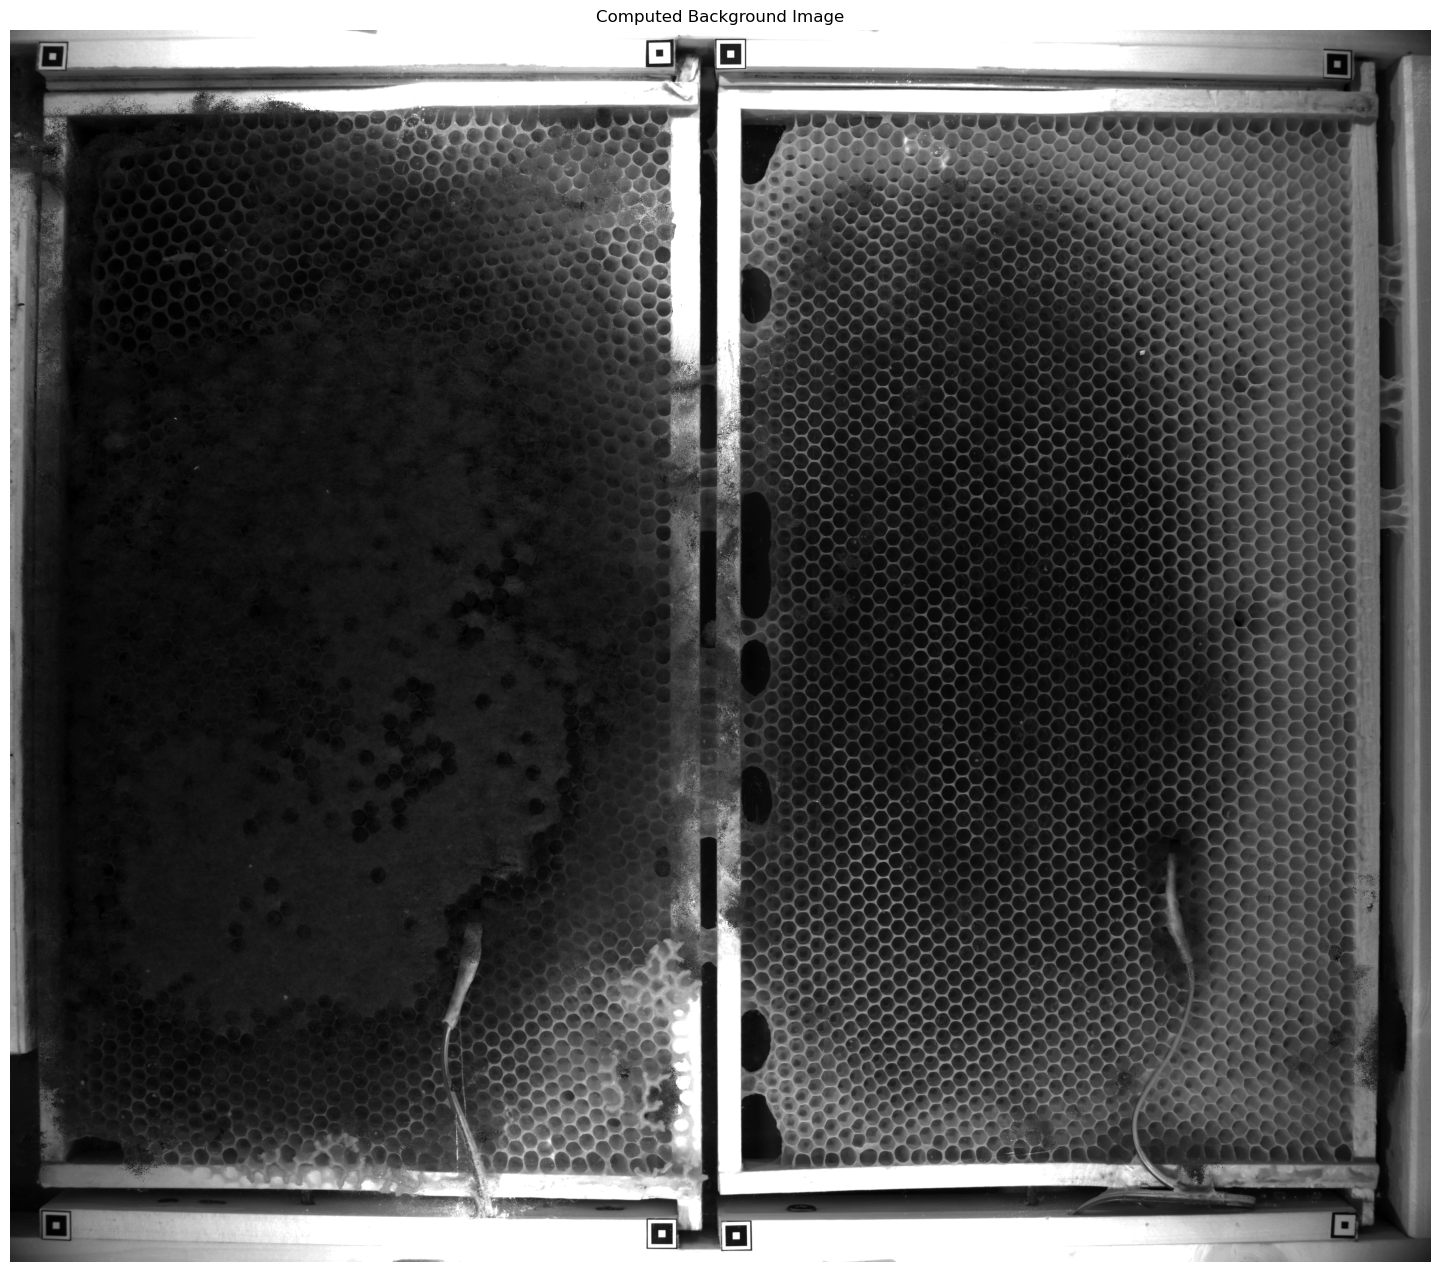

Background image saved to: /home/beesbook/tmp/background_1.png


In [ ]:
# --- Configuration ---
# for datecam_folder in datecam_folders[-1:]:
    # input_folder = os.path.join(base_folder,datecam_folder)
input_folder = '/home/beesbook/tmp/'

window_size = 10      # rolling window size for median
tile_size = (512, 512)  # tile size for computing mode
sampling_rate = 1 # use every Nth image from the folder

# --- Step 1: List files and determine image shape ---
file_list = sorted(glob(os.path.join(input_folder, "*.[pj][np][ge]*")))
file_list = [f for f in file_list if "background" not in os.path.basename(f).lower()]
file_list = file_list[::sampling_rate]
num_files = len(file_list)
print("Number of images to process:", num_files)

def read_image(f):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Warning: Could not read", f)
    return img

# Read the first image to get dimensions
first_img = read_image(file_list[0])
if first_img is None:
    raise ValueError("Cannot read the first image.")
H, W = first_img.shape
print("Image shape:", H, W)

# --- Step 2: Compute rolling median images and store in a memmap ---
# Number of median images = num_files - window_size + 1
num_medians = max(0, num_files - window_size + 1)
print("Number of median images to compute:", num_medians)

# Create a memmap file to hold the median images
memmap_file = os.path.join(tempfile.gettempdir(), "median_images.dat")
median_memmap = np.memmap(memmap_file, dtype='uint8', mode='w+', shape=(num_medians, H, W))

# Instead of loading all images into memory, maintain a sliding window list
window_imgs = []
# Preload first (window_size - 1) images
for f in file_list[:window_size - 1]:
    img = read_image(f)
    if not(np.mean(img)<10):
        window_imgs.append(img)

median_index = 0
for f in tqdm(file_list[window_size - 1:], desc="Computing rolling medians"):
    img = read_image(f)
    if (img is None) | (np.mean(img)<10):
        continue
    window_imgs.append(img)
    if len(window_imgs) == window_size:
        # Compute median across the window
        median_img = np.median(np.stack(window_imgs, axis=0), axis=0).astype(np.uint8)
        median_memmap[median_index, :, :] = median_img
        median_index += 1
        window_imgs.pop(0)
median_memmap.flush()
print("Rolling median computation complete.")

# --- Step 3: Compute pixel-wise mode over the median images in tiles ---
# Reopen memmap in read mode
median_memmap = np.memmap(memmap_file, dtype='uint8', mode='r', shape=(num_medians, H, W))
background = np.zeros((H, W), dtype=np.uint8)

# Determine number of tiles in each dimension
n_tiles_y = math.ceil(H / tile_size[0])
n_tiles_x = math.ceil(W / tile_size[1])
print("Processing image in", n_tiles_y, "x", n_tiles_x, "tiles.")

def process_tile(i, j):
    i_start = i
    j_start = j
    i_end = min(i_start + tile_size[0], H)
    j_end = min(j_start + tile_size[1], W)
    # Extract the tile from all median images
    tile = median_memmap[:, i_start:i_end, j_start:j_end]  # shape: (num_medians, tile_h, tile_w)
    # Compute the mode along axis 0 (over median images)
    tile_mode = mode(tile, axis=0, nan_policy='omit', keepdims=True)[0].squeeze(0).astype(np.uint8)
    return (i_start, i_end, j_start, j_end, tile_mode)

# Process tiles in parallel
results = Parallel(n_jobs=8)(
    delayed(process_tile)(i, j)
    for i in range(0, H, tile_size[0])
    for j in range(0, W, tile_size[1])
)

# Combine results into the background image
for res in results:
    i_start, i_end, j_start, j_end, tile_mode = res
    background[i_start:i_end, j_start:j_end] = tile_mode

print("Background image computed, shape:", background.shape)

# --- Step 4: Display and save the background image ---
plt.figure(figsize=(24, 16))
plt.imshow(background, cmap='gray')
plt.title("Computed Background Image")
plt.axis("off")
plt.show()

output_path = os.path.join(input_folder, "background_"+str(sampling_rate)+".png")
cv2.imwrite(output_path, background)
print("Background image saved to:", output_path)